In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error

# silence!
import warnings
warnings.filterwarnings("ignore")

---
### The VAR Model:
The Vector Autoregression model is a multivariate time-series algorithm that models the development of multiple target variables at the same time. 

An important distinction of VAR is variables are used as target variables and explanatory variables for each other at the same time, which is what makes it multivariate.

Model definition:
$$y_{t}=c+A_{1} y_{t-1}+A_{2} y_{t-2}+\cdots+A_{p} y_{t-p}+e_{t}$$

where:

* $y_t$ is a vector containg the current (present) values for each of the variables,

* $p$ is the parameter that controls the number of lags that the model will use (how many steps in the past to look),

* $c$ is a vector of constants, one for each target variable,

* $A$ is a vector of coefficients for each lag,

* $e_t$ is the error term.


<div class="alert alert-block alert-warning">
<b>Note:</b>
    
Like the univariate models we have seen in the past, the VAR model relies on the assumption of <b>stationarity</b>. This assumes that all of the variables used in the model are stationary. If some are and some are not, then differencing needs to be applied separately. 
</div>


<div class="alert alert-block alert-warning">
<b>Additional Note:</b>
  
VAR is only useful if the target variables are correlated with themselves. If there is little or no correlation between them, then we will not benefit from modeling them together with VAR. In that case, modeling the variables separately using several univariate models might be better.
</div>

---

### Import data:
Below we obtain an aggregated count for each store on a weekly time period. Then we plot.

The interest in arranging the data in this manner is to analyze and model the relationship between stores as separate variables. Remember from the discussion above that $y_t$ represents a vector of target variables. In essence, each column represents a store, and each row the "lag" value for said store. 

In [4]:
data = pd.read_csv('data/walmart_train.csv')
data = data.pivot_table(index='Date', columns='Store', values='Weekly_Sales')
data.head(5)

Store,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,22516.313699,29273.828219,7101.880308,29248.546164,5115.695161,22638.836986,6898.964444,14552.711449,8862.992742,29240.650000,...,12303.861579,10938.912857,7029.336078,18097.011765,14520.924638,15303.284225,11812.695870,13479.776667,5856.061458,13293.873284
2010-02-12,22804.964444,29691.798611,6573.890000,29177.431867,4797.318462,22003.888493,7487.213143,14011.287324,8772.658413,29405.790811,...,12690.910811,11038.597917,6844.298000,17834.212254,13647.689857,15150.089296,12249.148085,14846.065000,5976.190208,9661.597647
2010-02-19,22081.755753,29102.075890,6486.802923,28080.277534,4668.424154,21765.806528,7137.472394,13770.862429,7866.583077,28179.101067,...,12375.816579,10632.968750,6544.758400,17834.666232,13089.845714,15029.067714,10383.568776,13729.115625,5582.422917,12192.232464
2010-02-26,19579.549861,25549.277671,6463.569206,26023.362703,4158.178923,19629.496027,6987.087887,12283.943623,7402.707344,26404.933684,...,11474.857436,10481.955510,6962.973542,17185.029706,12167.850845,13588.242877,10685.012609,12889.641458,5810.192979,10598.452143
2010-03-05,21298.721644,27274.152466,6590.508571,27375.797778,4513.370469,21936.285205,6921.402113,12415.548592,8052.347302,26494.534533,...,12636.932368,10385.113600,7596.732449,18089.345857,13945.806761,14979.682958,12064.617826,14317.392391,5692.345400,11611.212239


### Plot:

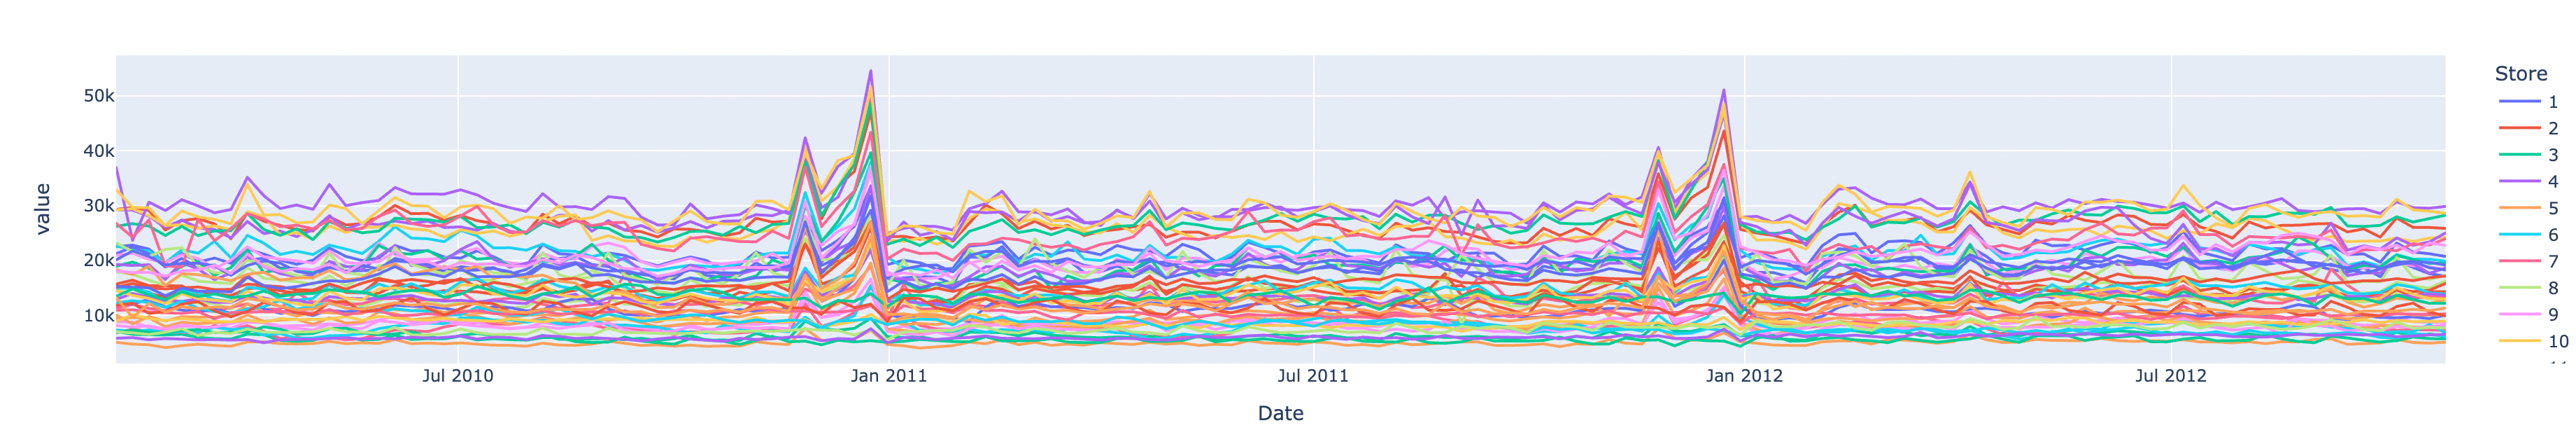

In [21]:
px.line(data)
Image(filename='./images/ch9_storesales.png', width=1600)

As we can see above, all of the stores (variables) tend to peak at the same moment. We can check how correlated they are with each other as well. 

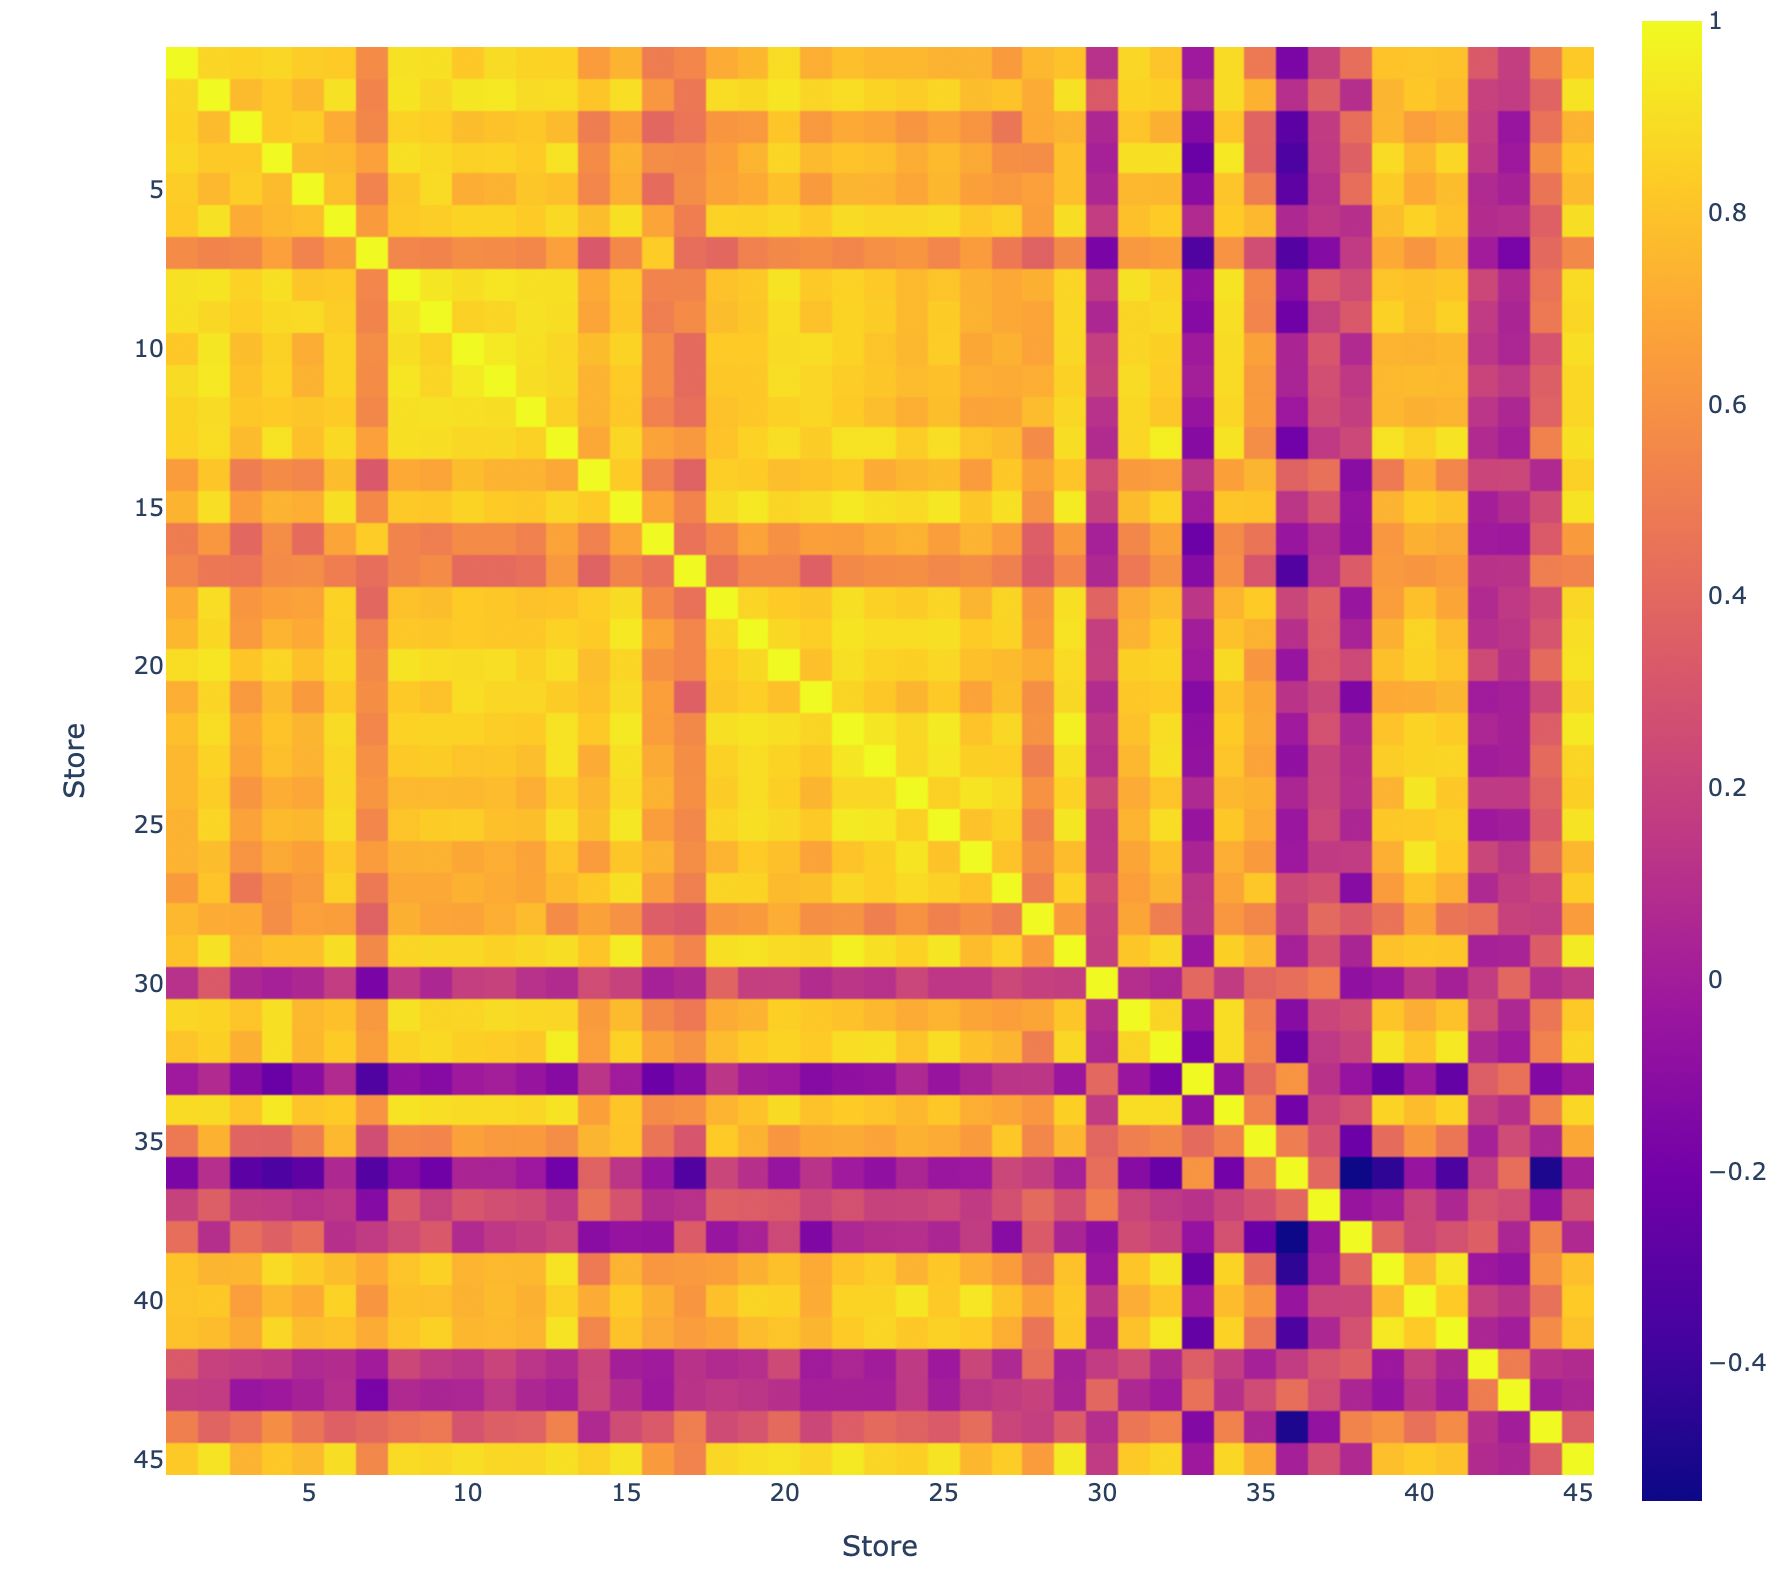

In [24]:
px.imshow(data.corr(), width = 900, height = 900)
Image(filename='./images/ch9_corrplot.png', width=900)

### Fit the VAR model:

In [20]:
# split:
train = data.iloc[:-10,:]
test = data.iloc[-10:,:]

# initialize and fit (we select a max of 2 lags)
model = VAR(train)
results = model.fit(maxlags=2)

# obtain forecast:
lag_order = results.k_ar
print(f'lag order: {lag_order}')
fcst = results.forecast(train.values[-lag_order:], 10)

# print accuracy:
model_accuracy = 1 - mean_absolute_percentage_error(test, fcst)
print(f'model accuracy: {model_accuracy}')

lag order: 2
model accuracy: 0.8911349592624213


<div class="alert alert-block alert-warning">
<b>Note:</b>
  
According to the text ("Advanced Forecasting with Python", page 138) the reason for choosing maxlags=2, is because choosing a higher value would require more parameters to be estimated than it's possible with the current data. As explained there, one of the negative aspects of VAR is that it requires many parameters to be estimated. This creates the burden of an enormous amount of data.
</div>
